In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    BertPreTrainedModel, 
    TrainingArguments, 
    Trainer
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA RTX A6000


In [2]:
# --- 2. 設定 ---

# 最終版のクリーニング済みデータ
TRAINING_FILE = "data/processed/training_dataset_abstract_cleaned_v3.csv"

# 使用するベースモデル（SciBERT）
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"

# 訓練済みモデルの保存先
OUTPUT_MODEL_DIR = "models/sbert_contrastive_v1"

# モデルのハイパーパラメータ
MAX_LENGTH = 512
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
CONTRASTIVE_MARGIN = 1.0
METRICS_THRESHOLD = 0.5 # 評価時に「正例」と判断する距離のしきい値

print("Configuration set for Contrastive Loss.")

Configuration set for Contrastive Loss.


In [3]:
# --- 3. カスタムモデルクラスの定義 ---

class MeanPooling(nn.Module):
    """アテンションマスクを考慮したMean Pooling層"""
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

class SiameseContrastiveModel(BertPreTrainedModel):
    """
    S-BERT (Contrastive) モデル
    """
    def __init__(self, config):
        super(SiameseContrastiveModel, self).__init__(config)
        self.bert = AutoModel.from_config(config)
        self.pooler = MeanPooling()
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        input_ids_b=None,
        attention_mask_b=None,
        labels=None,
        **kwargs
    ):
        # 論文Aと論文Bを、同じ重みのBERTで個別に処理
        output_a = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output_b = self.bert(input_ids=input_ids_b, attention_mask=attention_mask_b)

        # Mean Poolingでベクトル化
        vec_x = self.pooler(output_a.last_hidden_state, attention_mask)
        vec_y = self.pooler(output_b.last_hidden_state, attention_mask_b)

        # 損失(loss)はこのモデル内では計算せず、Trainer側で計算する
        # logitsフィールドに、計算した2つのベクトルをタプルとして渡す
        return SequenceClassifierOutput(
            loss=None,
            logits=(vec_x, vec_y),
            hidden_states=None,
            attentions=None,
        )

print("Custom model class 'SiameseContrastiveModel' defined.")

Custom model class 'SiameseContrastiveModel' defined.


In [4]:
# --- 4. データセットの読み込みとトークン化 ---
print(f"Loading dataset: {TRAINING_FILE}")
df = pd.read_csv(TRAINING_FILE)
df = df.dropna(subset=['abstract_a', 'abstract_b', 'label'])
df['label'] = df['label'].astype(int)

raw_dataset = Dataset.from_pandas(df)
dataset_split = raw_dataset.train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': dataset_split['train'],
    'validation': dataset_split['test']
})
print(f"Dataset loaded: {dataset}")

print("Initializing tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_siamese_function(examples):
    tokenized_a = tokenizer(examples["abstract_a"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    tokenized_b = tokenizer(examples["abstract_b"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    return {
        "input_ids": tokenized_a["input_ids"],
        "attention_mask": tokenized_a["attention_mask"],
        "input_ids_b": tokenized_b["input_ids"],
        "attention_mask_b": tokenized_b["attention_mask"],
    }

print("Tokenizing dataset for Siamese model...")
tokenized_datasets = dataset.map(tokenize_siamese_function, batched=True, num_proc=4)

tokenized_datasets = tokenized_datasets.remove_columns(["abstract_a", "abstract_b", "data_paper_doi"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
print("Tokenization complete.")

Loading dataset: data/processed/training_dataset_abstract_cleaned_v3.csv
Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['abstract_a', 'abstract_b', 'label', 'data_paper_doi'],
        num_rows: 27699
    })
    validation: Dataset({
        features: ['abstract_a', 'abstract_b', 'label', 'data_paper_doi'],
        num_rows: 6925
    })
})
Initializing tokenizer...


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing dataset for Siamese model...


Map (num_proc=4):   0%|          | 0/27699 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/6925 [00:00<?, ? examples/s]

Tokenization complete.


In [5]:
# --- 5. カスタムTrainerの定義 ---

class ContrastiveTrainer(Trainer):
    """
    Contrastive Lossを計算するためにTrainerを継承
    """
    def __init__(self, *args, margin=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.margin = margin
        print(f"ContrastiveTrainer initialized with margin={self.margin}")

    def compute_loss(self, model, inputs, return_outputs=False):
        # 'labels' を inputs 辞書から取り出す
        labels = inputs.pop("labels")
        
        # モデルのforwardパスを実行（vec_x, vec_yがlogitsとして返ってくる）
        outputs = model(**inputs)
        vec_x, vec_y = outputs.logits
        
        # 損失関数の計算 (Cosine Distance)
        distance = 1 - F.cosine_similarity(vec_x, vec_y)
        
        # Contrastive Lossの計算
        loss_positive = distance
        loss_negative = F.relu(self.margin - distance) # marginより遠ければ0
        
        # ラベルに応じて損失を適用
        loss = (labels.float() * loss_positive) + ((1 - labels.float()) * loss_negative)
        loss = loss.mean()

        return (loss, outputs) if return_outputs else loss

print("Custom 'ContrastiveTrainer' defined.")

Custom 'ContrastiveTrainer' defined.


In [6]:
# --- 6. モデルのロードと訓練設定 ---
print(f"Loading custom model: {MODEL_CHECKPOINT}")
model = SiameseContrastiveModel.from_pretrained(MODEL_CHECKPOINT, num_labels=2).to(device)
print("Custom model loaded.")

# 評価指標を計算する関数 (距離ベース)
def compute_metrics(eval_pred):
    # eval_pred.predictions は (vec_x, vec_y) のタプル
    vec_x, vec_y = eval_pred.predictions
    labels = eval_pred.label_ids
    
    # 距離を計算
    distance = 1 - F.cosine_similarity(torch.tensor(vec_x), torch.tensor(vec_y))
    
    # しきい値(METRICS_THRESHOLD)に基づいて予測 (0 or 1)
    # 距離がしきい値より「小さければ」正例(1)、大きければ負例(0)
    preds = (distance < METRICS_THRESHOLD).int()
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# 訓練の設定
training_args = TrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=100,
)
print("Training arguments and metrics set.")

Loading custom model: allenai/scibert_scivocab_uncased
Custom model loaded.
Training arguments and metrics set.


In [7]:
# --- 7. 訓練の開始 ---
trainer = ContrastiveTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    margin=CONTRASTIVE_MARGIN # カスタムTrainerにマージンを渡す
)

print("\n--- Starting Model Training (Contrastive Loss) ---")
trainer.train()
print("--- Model Training Complete ---")

ContrastiveTrainer initialized with margin=1.0

--- Starting Model Training (Contrastive Loss) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.020300,0.021672,0.980361,0.952247,0.926230,0.979769
2,0.012200,0.015274,0.985848,0.965248,0.947772,0.983382
3,0.009800,0.012698,0.987870,0.970021,0.958392,0.981936


--- Model Training Complete ---


In [8]:
# --- 8. モデルの保存 ---
print("Training complete. Saving best model...")
best_model_path = os.path.join(OUTPUT_MODEL_DIR, "best_model")
trainer.save_model(best_model_path)
print(f"Model saved to {best_model_path}")

Training complete. Saving best model...
Model saved to models/sbert_contrastive_v1/best_model



--- Visualizing Training Results ---


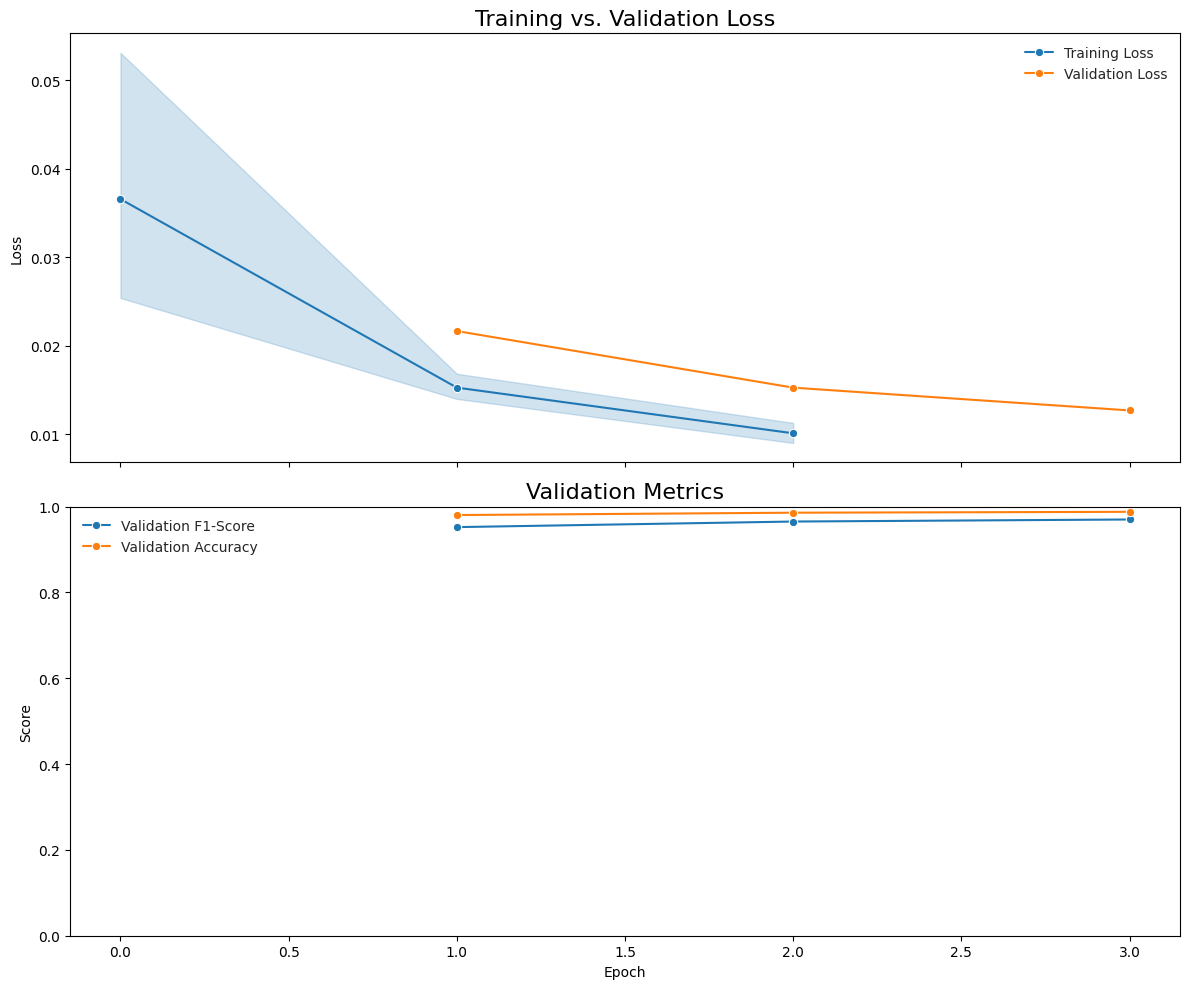


--- Best Model Evaluation Metrics (from validation set) ---
Best Epoch (based on min eval_loss): 3.0
Best Validation Loss: 0.0127
Best Validation F1: 0.9700
Best Validation Accuracy: 0.9879


In [9]:
# --- 9. 訓練結果の可視化 ---
print("\n--- Visualizing Training Results ---")
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

df_train = df_log[df_log['loss'].notna()].copy()
df_eval = df_log[df_log['eval_loss'].notna()].copy()

if 'epoch' in df_train.columns:
    df_train['epoch'] = df_train['epoch'].astype(int)
if 'epoch' in df_eval.columns:
    df_eval['epoch'] = df_eval['epoch'].astype(int)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

sns.lineplot(data=df_train, x='epoch', y='loss', label='Training Loss', ax=ax1, marker='o')
sns.lineplot(data=df_eval, x='epoch', y='eval_loss', label='Validation Loss', ax=ax1, marker='o')
ax1.set_title('Training vs. Validation Loss', fontsize=16)
ax1.set_ylabel('Loss')
ax1.legend()

sns.lineplot(data=df_eval, x='epoch', y='eval_f1', label='Validation F1-Score', ax=ax2, marker='o')
sns.lineplot(data=df_eval, x='epoch', y='eval_accuracy', label='Validation Accuracy', ax=ax2, marker='o')
ax2.set_title('Validation Metrics', fontsize=16)
ax2.set_ylabel('Score')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n--- Best Model Evaluation Metrics (from validation set) ---")
if not df_eval.empty:
    best_run = df_eval.loc[df_eval['eval_loss'].idxmin()]
    print(f"Best Epoch (based on min eval_loss): {best_run['epoch']}")
    print(f"Best Validation Loss: {best_run['eval_loss']:.4f}")
    print(f"Best Validation F1: {best_run['eval_f1']:.4f}")
    print(f"Best Validation Accuracy: {best_run['eval_accuracy']:.4f}")
else:
    print("No evaluation steps were completed.")